In [1]:
import scanpy as sc
import pandas as pd
import anndata
import math

In [3]:
## Read aggregated data
adata = sc.read_10x_h5("/corgi/cellbuster/10xpbmc/aggr/outs/filtered_feature_bc_matrix.h5",gex_only=False)

/home/mahogny/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [27]:
libs

,library_id,atac_fragments,per_barcode_metrics,gex_molecule_info,libnum
0,10k_PBMC_Multiome_nextgem_Chromium_Controller,/corgi/cellbuster/10xpbmc/cellranger-arc/10k_P...,/corgi/cellbuster/10xpbmc/cellranger-arc/10k_P...,/corgi/cellbuster/10xpbmc/cellranger-arc/10k_P...,1
1,10k_PBMC_Multiome_nextgem_Chromium_X,/corgi/cellbuster/10xpbmc/cellranger-arc/10k_P...,/corgi/cellbuster/10xpbmc/cellranger-arc/10k_P...,/corgi/cellbuster/10xpbmc/cellranger-arc/10k_P...,2
2,pbmc_granulocyte_sorted_10k,/corgi/cellbuster/10xpbmc/cellranger-arc/pbmc_...,/corgi/cellbuster/10xpbmc/cellranger-arc/pbmc_...,/corgi/cellbuster/10xpbmc/cellranger-arc/pbmc_...,3
3,pbmc_granulocyte_unsorted_10k,/corgi/cellbuster/10xpbmc/cellranger-arc/pbmc_...,/corgi/cellbuster/10xpbmc/cellranger-arc/pbmc_...,/corgi/cellbuster/10xpbmc/cellranger-arc/pbmc_...,4


In [96]:
## Read list of aggregated libraries (same as used for cellranger aggr)
libs=pd.read_csv("/corgi/cellbuster/10xpbmc/libs.csv")
libs["libnum"]=range(1,len(libs.index)+1)
libs["dataset"]=libs["library_id"]

## Read telomemore metadata. Add aggr libs mapping
telo=pd.read_csv("/corgi/cellbuster/10xpbmc/summary_kmer.java.csv")
telo=telo.merge(libs[["dataset","libnum"]])
#Calculate barcode after aggr
telo["aggr_barcode"]=[bc.split("-")[0]+"-"+str(libnum) for (bc,libnum) in zip(telo["barcode"],telo["libnum"])]

##Only retain cells analyzed by telomemore; reorder adata to match telomemore metadata
adata = adata[telo["aggr_barcode"],:]

##Transfer metadata
adata.obs["telo_cnt"] = list(telo["dedupcnt_CCCTAA"])
adata.obs["telo_total"] = list(telo["totalcnt_CCCTAA"])
adata.obs["telo_libnum"] = list(telo["libnum"])

## Normalize telomeres
adata.obs["telo_norm"] = adata.obs["telo_cnt"] / adata.obs["telo_total"]

## Compute rank quantile for each cell.
## Do it for each library to avoid batch effects (not always needed, but good default)
dict_norm_rank = {}
for curlib in set(adata.obs["telo_libnum"]):
    adata.obs["telo_libnum"]==curlib
    thebc = adata.obs.index[adata.obs["telo_libnum"]==curlib]
    thenorm = adata.obs["telo_norm"][adata.obs["telo_libnum"]==curlib]
    thenorm = thenorm.rank() / len(thebc)
    for (bc,norm) in zip(thebc, thenorm):
        dict_norm_rank[bc] = norm
adata.obs["telo_norm_rank"] = [dict_norm_rank[bc] for bc in adata.obs.index]


/tmp/ipykernel_2252989/1288623646.py:16: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["telo_cnt"] = list(telo["dedupcnt_CCCTAA"])
/home/mahogny/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [110]:
#################################################################
######## Continue analysis as usual #############################
#################################################################

In [97]:
## Check generated rank(nTA)
adata.obs

,telo_cnt,telo_total,telo_libnum,telo_norm,telo_norm_rank
AAACAGCCAACAACAA-1,20,52,1,0.384615,0.096810
AAACAGCCAAGGACCA-1,32,49,1,0.653061,0.868347
AAACAGCCACAATGCC-1,36,65,1,0.553846,0.706716
AAACAGCCATGAGCAG-1,6,7,1,0.857143,0.953746
AAACATGCAAGATTCT-1,20,30,1,0.666667,0.881629
...,...,...,...,...,...
TTTGTTGGTGTTAAAC-3,13,30,3,0.433333,0.783241
TTTGTTGGTTAGGATT-3,15,38,3,0.394737,0.692806
TTTGTTGGTTGCAGTA-3,0,0,3,NaN,NaN
TTTGTTGGTTGGTTAG-3,23,70,3,0.328571,0.435241


In [104]:
adata.var['MT'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

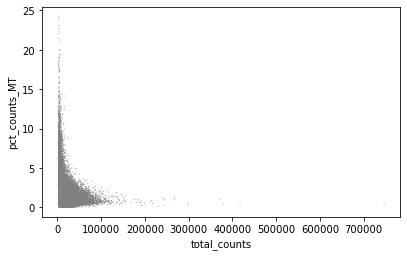

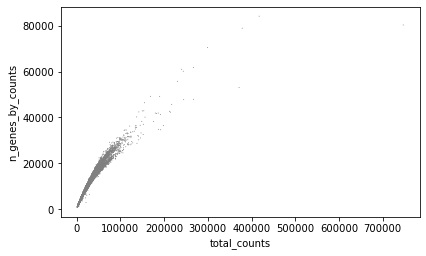

In [106]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [108]:
#May want to test without these cutoffs as well
adata = adata[adata.obs.pct_counts_MT < 10, :]    
adata = adata[adata.obs.n_genes_by_counts < 8000, :]
adata

View of AnnData object with n_obs × n_vars = 7362 × 171913
    obs: 'telo_cnt', 'telo_total', 'telo_libnum', 'telo_norm', 'telo_norm_rank', 'telo_libnum_s', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

/tmp/ipykernel_2252989/2054844670.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["batch"] = [str(x) for x in adata.obs["telo_libnum"]]
/home/mahogny/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mahogny/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/mahogny/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True

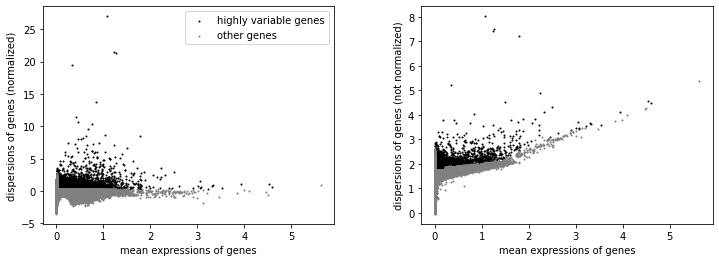

/home/mahogny/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/mahogny/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [109]:
adata.obs["batch"] = [str(x) for x in adata.obs["telo_libnum"]]
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=5, min_disp=0.3, batch_key="batch")
sc.pl.highly_variable_genes(adata)

#Keep raw data; reduce matrix
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='arpack')
if True:
    import bbknn
    bbknn.bbknn(adata, batch_key='batch')
else:
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

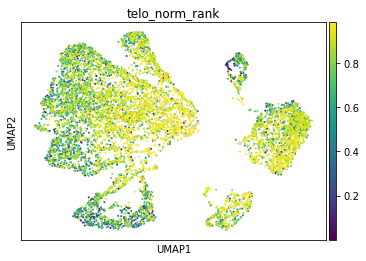

In [113]:
## Plotting of rank(nTA)
sc.pl.umap(adata,color=["telo_norm_rank"],ncols=2)
